# DiT Reproduction 

In [11]:
import numpy as np
import torch as T
import torch.nn as nn
import random
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from PIL import Image

hippo_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

hippo_dataset = []
hippo_dir = os.path.expanduser("~/Downloads/hippo_images")
for filename in os.listdir(hippo_dir):
    if filename.lower().endswith('.png'):
        img_path = os.path.join(hippo_dir, filename)
        img = Image.open(img_path)  # Remove grayscale conversion
        img_tensor = hippo_transform(img)
        img_tensor = T.rot90(img_tensor, dims=(1, 2))
        hippo_dataset.append(img_tensor)

hippo_dataset = T.stack(hippo_dataset)

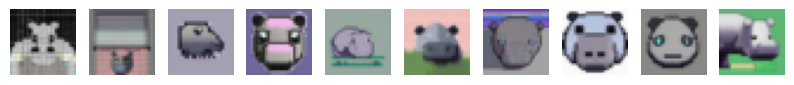

In [12]:
fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(hippo_dataset[i].T)
    ax.axis("off")

In [4]:
mps = T.device("mps")

In [13]:
class LayerNorm(nn.Module):
    def __init__(self, latent_dim):
        super(LayerNorm, self).__init__()
        self.mean = nn.Parameter(T.zeros(latent_dim))
        self.sd = nn.Parameter(T.ones(latent_dim))

    def forward(self, x):
        shape = x.shape
        x = x.flatten(1)
        return (x * self.sd + self.mean).reshape(shape)
        
class VAE(nn.Module):
    def __init__(self, latent_dim=64, layers=4, input_dim=64):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(1*i, 1*(i+1), 2, stride=2),
                    LayerNorm((i+1)*(input_dim//(2**i))**2),
                    nn.LeakyReLU(0.1)
                ) for i in range(1, layers+1)
            ] + [  nn.Conv2d(1*(layers+1), 1, 1) ]
        )
        latent_dim = (input_dim//2**layers)**2
        self.mu = nn.Sequential(nn.Linear(latent_dim, latent_dim))
        self.logvar = nn.Sequential(nn.Linear(latent_dim, latent_dim))

        self.decoder = nn.ModuleList(
            [nn.ConvTranspose2d(1, layers+1, 1)] +
            [
                nn.Sequential(
                    nn.ConvTranspose2d(i+1, i, 2, stride=2),
                    LayerNorm(i*(64//(2**(i-1)))**2),
                    nn.LeakyReLU(0.1)
                ) for i in range(layers, 0, -1)
            ]
        )

    def KL(self, mean, sd):
        sd = T.clip(sd, min=1e-4, max=3)
        mean = T.clip(mean, min=1e-4, max=3)
        return (sd - 0.5 + (1+mean**2)/(2*sd.exp()**2)).mean()

    def up(self, x):
        for layer in self.decoder:
            x = layer(x)
        return x

    def down(self, x):
        for layer in self.encoder:
            x = layer(x)
        
        x = x.flatten(1)
        return self.mu(x), self.logvar(x)

    def forward(self, x):
        for layer in self.encoder:
            x = layer(x)
        shape = x.shape
        x = x.flatten(1)
        self.mean = self.mu(x)  # (b, S)
        self.sd = self.logvar(x)
        kl = self.KL(self.mean, self.sd)
        self.sd = T.exp(0.5 * self.sd)
        # sample
        sample = self.mean + self.sd * T.randn_like(self.sd)
        x = sample
        x = x.reshape(shape)
        for layer in self.decoder:
            x = layer(x)
        return kl, x

In [16]:
encoder = VAE(layers=2, latent_dim=32, input_dim=64).to(mps)
state_dict = T.load("vae.pth")
encoder.load_state_dict(state_dict)

/var/folders/gl/2h8nn4ps031g1jysgll17wz00000gn/T/ipykernel_47058/2864650579.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = T.load("vae.pth")


<All keys matched successfully>

## Data Exploration/Dataset Generation

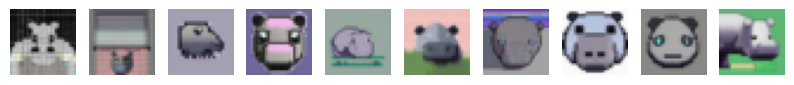

In [15]:
fig = plt.figure(figsize=(10, 10))

for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(hippo_dataset[i].T)
    ax.axis("off")

In [16]:
import math
s = 1e-5
cos_scheduler = lambda x: math.cos((x/50 + s)/(1+s) * math.pi/2)**2

## noise scheduling

In [63]:
mps = T.device("mps")

Mean: 0.4335
Standard Deviation: 0.2727
Minimum: 0.0353
Maximum: 0.9255


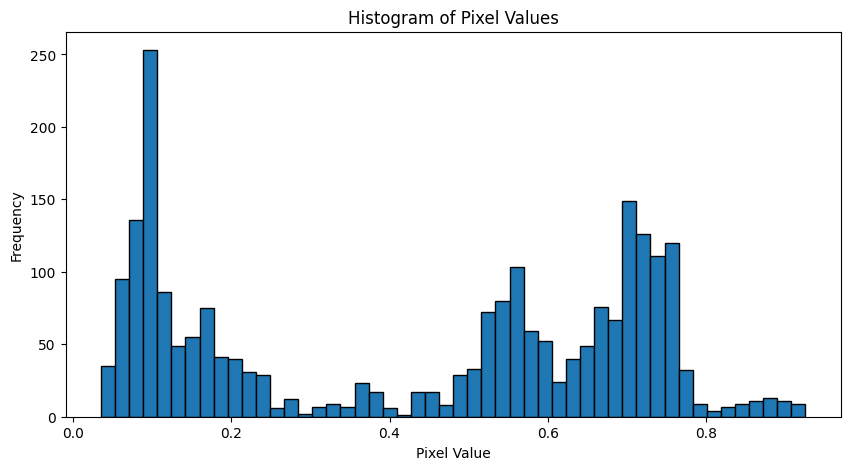

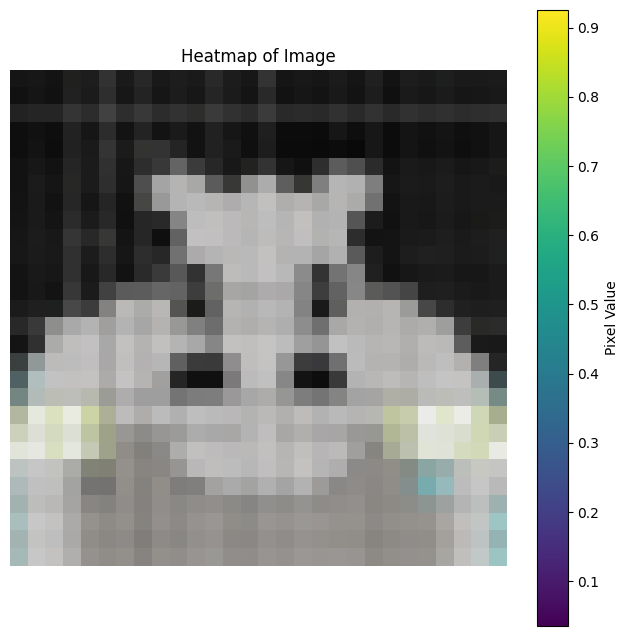

In [206]:
im = hippo_dataset[0]
# get summary stats
# Calculate summary statistics
mean = T.mean(im)
std = T.std(im)
min_val = T.min(im)
max_val = T.max(im)

# Print summary statistics
print(f"Mean: {mean:.4f}")
print(f"Standard Deviation: {std:.4f}")
print(f"Minimum: {min_val:.4f}")
print(f"Maximum: {max_val:.4f}")

# Create histogram
plt.figure(figsize=(10, 5))
plt.hist(im.flatten(), bins=50, edgecolor='black')
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

# Create heatmap
plt.figure(figsize=(8, 8))
plt.imshow(im.T, cmap='viridis')
plt.colorbar(label='Pixel Value')
plt.title('Heatmap of Image')
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.17821765..1.0428257].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.24783148..1.0508271].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.25731665..1.0330348].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.2510835..1.0503833].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.24397716..1.0522845].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28037477..1.0536578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.25802186

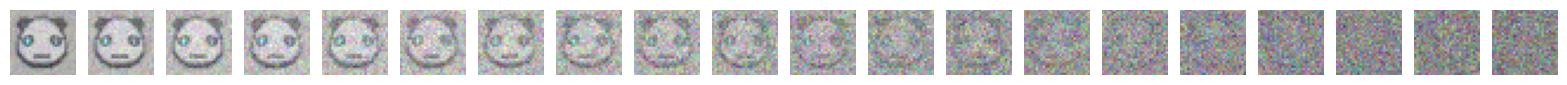

In [207]:
beta = 0.15
alpha = 1-beta

alphas = [alpha*cos_scheduler(i) for i in range(20)]
alphas_prod = T.cumprod(T.tensor(alphas), dim=0)

noise = lambda shape: T.normal(mean=T.ones(shape)*0.5, std=0.1)

def get_noised(img, t):
    #img = img/img.max()
    no = noise(img.shape)
    return no, T.sqrt(t)*img + T.sqrt(1-t)*no

def get_noised_pairs(img, c, r=20):
    pairs = []
    #img = encoder.down(img.unsqueeze(0).to(mps))[0].squeeze().cpu().detach().reshape(16, 16)
    for i in range(r):
        # scaling the original image down, and scaling the noise to the inverse amount, so distributions stay ~similar
        no, noised = get_noised(img, alphas_prod[i])
        pairs.append((
            noised,
            no,
            r-i,
            c
        ))
    return pairs

img = hippo_dataset[8]

fig = plt.figure(figsize=(25, 25))

p = get_noised_pairs(img, 0)

for i in range(20):
    ax = fig.add_subplot(1, 25, i+1)
    img = p[i][0]
    #img = encoder.up(img.unsqueeze(0).unsqueeze(0).to(mps))[0].squeeze().cpu().detach()
    ax.imshow(img.T)
    ax.axis("off")

In [ ]:
mnist = [get_noised_pairs(img[0], img[1]) for img in mnist]
mnist = [j for i in mnist for j in i]

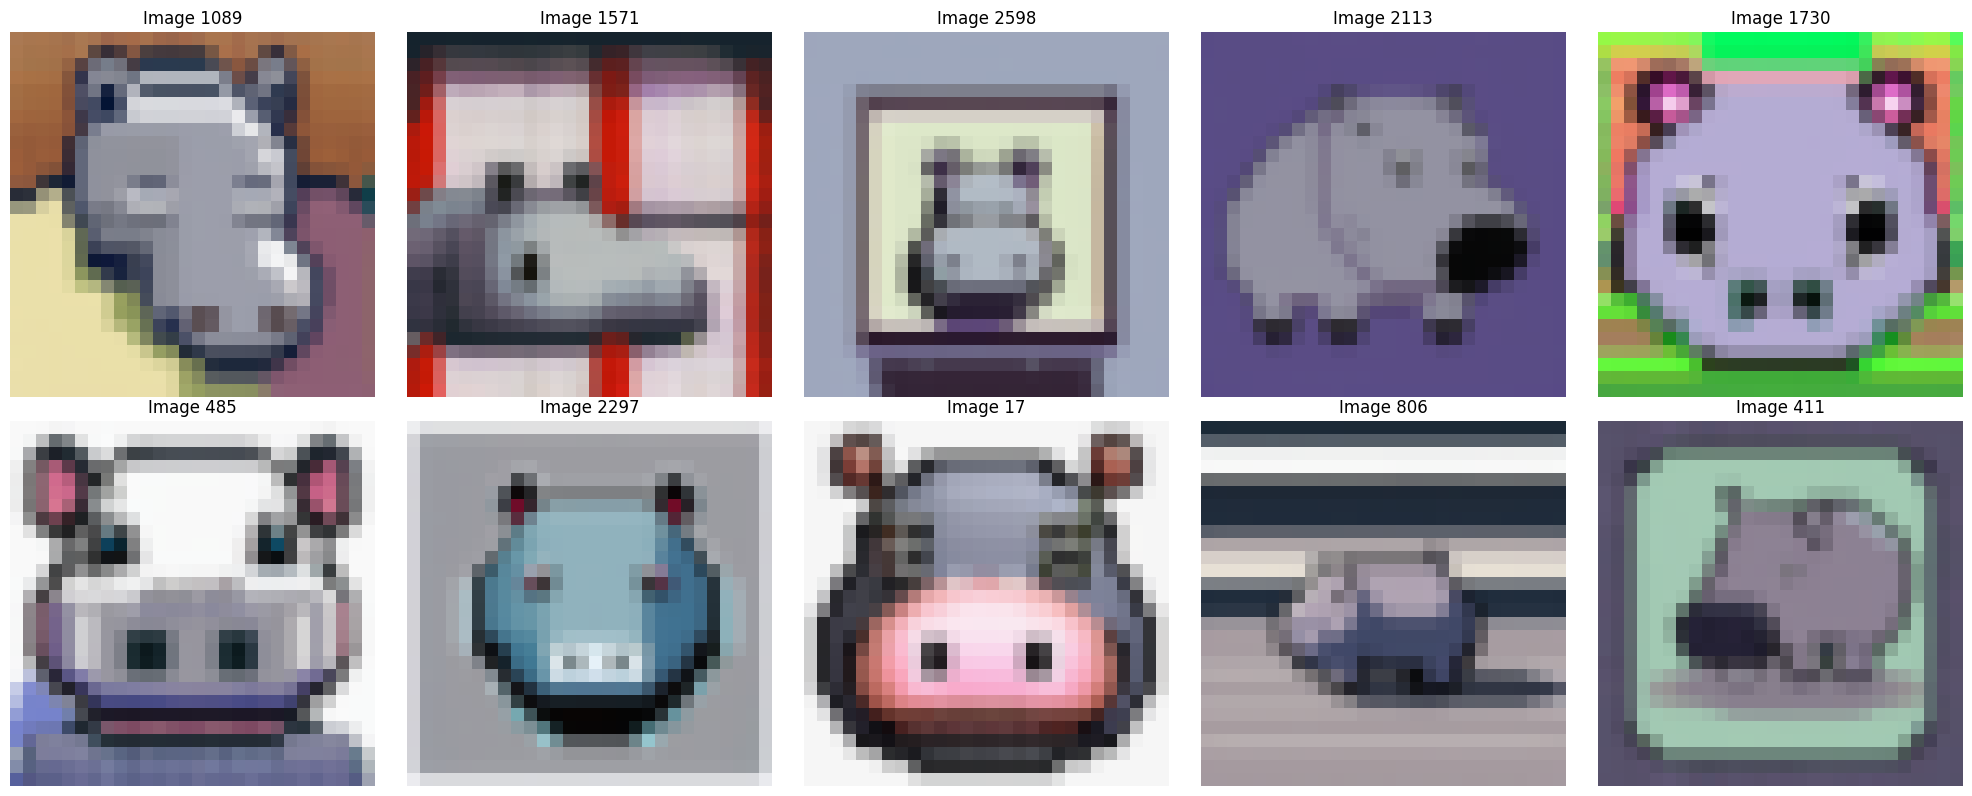

In [57]:
# View 10 random images from hippo_dataset
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
random_indices = np.random.choice(len(hippo_dataset), 10, replace=False)

for i, ax in enumerate(axes.flat):
    img = hippo_dataset[random_indices[i]]
    ax.imshow(img.squeeze().T, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Image {random_indices[i]}")

plt.tight_layout()
plt.show()


### Model Classes

In [58]:
class LayerNorm(nn.Module):
    def __init__(self, latent_dim):
        super(LayerNorm, self).__init__()
        self.mean = nn.Parameter(T.zeros(latent_dim))
        self.sd = nn.Parameter(T.ones(latent_dim))

    def forward(self, x):
        return x * self.sd + self.mean

class AdaLN(nn.Module):
    def __init__(self, latent_dim, out_dim=None):
        super(AdaLN, self).__init__()
        out_dim = latent_dim if out_dim == None else out_dim
        self.mean = nn.Linear(latent_dim, out_dim)
        self.sd = nn.Linear(latent_dim, out_dim)
        self.ln = LayerNorm(out_dim)

    def forward(self, x, t, c):
        t = F.silu(t + c)
        mean = self.mean(t)
        sd = self.sd(t)

        #mean = T.clip(mean, max=3)
        #sd = T.clip(sd, max=3)
        return self.ln(x*sd + mean)

In [145]:
class Transformer(nn.Module):
    def __init__(self, seq_len, heads, latent_dim, dim_out, steps=21, classes=10, mask=None, dropout=0.05):
        super(Transformer, self).__init__()
        self.proj = nn.Linear(latent_dim, latent_dim)  # Changed from seq_len to latent_dim
        self.proj_q = nn.Linear(latent_dim, latent_dim)
        self.proj_k = nn.Linear(latent_dim, latent_dim)
        self.proj_v = nn.Linear(latent_dim, latent_dim)

        self.layer_norm1 = AdaLN(latent_dim)
        self.layer_norm2 = AdaLN(latent_dim)

        self.mask = mask
        self.seq_len = seq_len
        self.heads = heads
        self.latent_dim = latent_dim

        self.ffn = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 4),
            nn.GELU(),
            nn.Linear(latent_dim * 4, latent_dim),
        )
        
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x, t, c):
        x = x.permute(0, 2, 1)
        # x shape: (bs, seq_len, latent_dim)
        bs, seq_len, _ = x.shape
        res = x
        x = self.proj(x)  # (bs, seq_len, latent_dim)
        x = self.layer_norm1(x, t, c)
        
        q = self.proj_q(x)
        k = self.proj_k(x)
        v = self.proj_v(x)

        q = q.view(bs, seq_len, self.heads, self.latent_dim // self.heads).transpose(1, 2)
        k = k.view(bs, seq_len, self.heads, self.latent_dim // self.heads).transpose(1, 2)
        v = v.view(bs, seq_len, self.heads, self.latent_dim // self.heads).transpose(1, 2)

        attn = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        attn = attn.permute(0, 2, 1, 3).reshape(bs, seq_len, self.latent_dim)
        x = res + attn
        x = self.layer_norm2(x, t, c)
        return self.ffn(x).permute(0, 2, 1)

In [171]:
class PositionalEmbedding(nn.Module):
    def __init__(self, seq_len, patch_size, d_model, channels=3):
        super(PositionalEmbedding, self).__init__()
        dims = [T.arange(0,seq_len)/10000**(i/d_model) for i in range(patch_size**2 * channels)]
        dims = T.stack(dims, dim=0).to(mps)

        dims[0::2] = T.sin(dims[0::2])
        dims[1::2] = T.cos(dims[1::2])

        self.pos = dims.unsqueeze(0)  # Add batch dimension

    def forward(self, x):
        return x + self.pos.expand(x.shape[0], -1, -1)

In [103]:
x.shape

torch.Size([1, 3, 28, 28])

In [104]:
F.unfold(x, kernel_size=(4, 4), stride=4).shape

torch.Size([1, 48, 49])

In [172]:
class DiT(nn.Module):
    def __init__(self, layers, seq_len, patch_size, n_heads, steps=21, classes=10, latent_dim=None):
        super(DiT, self).__init__()
        #assert (seq_len**0.5).is_integer()

        self.latent_dim = latent_dim if latent_dim != None else seq_len // 2
        self.size = int(patch_size * seq_len**0.5)
        self.patch_size = patch_size
        self.seq_len = seq_len

        self.emb = PositionalEmbedding(seq_len, patch_size, 3)

        self.transformer_block = nn.ModuleList(
            [Transformer(seq_len, n_heads, latent_dim, seq_len, steps=steps, classes=classes) for _ in range(layers)]
        )

        self.layer_norm = AdaLN(latent_dim, seq_len)

        self.proj_out = nn.Linear(seq_len, seq_len)

        self.emb_step = nn.Embedding(steps, latent_dim)
        self.emb_time = nn.Embedding(classes, latent_dim)
    
    def forward(self, x, t, c):
        bs = x.shape[0]
        x = F.unfold(x, kernel_size=(self.patch_size, self.patch_size), stride=self.patch_size).transpose(1, 2)
        x = x.permute(0, 2, 1)
        x = self.emb(x)

        t = self.emb_step(t)
        c = self.emb_time(c)

        
        for layer in self.transformer_block:
            x = layer(x, t, c)
    
        x = self.layer_norm(x, t , c)
        x = self.proj_out(x)
        return F.fold(x, output_size=(self.size,self.size), kernel_size=(self.patch_size, self.patch_size), stride=self.patch_size)

In [ ]:
# model = nn.Sequential(*[Transformer(49, 10, 100, 49) for _ in range(3)])

In [ ]:
# model = DiT(3, 49, 4, 10, latent_dim=100)

In [150]:
bs = 32
dataloader = DataLoader(hippo_dataset, batch_size=bs, shuffle=True)

In [208]:
import torch.nn.utils as utils
max_norm = 10
device = T.device("mps")
steps=25
model = DiT(3, 196, 2, 4, latent_dim=12, steps=21, classes=11)
# model = T.compile(model)
opt = T.optim.AdamW(model.parameters(), lr=1e-3)
loss_graph = []

model.to(device)
i = 0
for epoch in range(300):
    for img in dataloader:
        # timesteps
        bs = img.shape[0]
        steps = (T.rand(bs)*len(alphas_prod)).int()

        t = alphas_prod[steps].view(bs, 1, 1, 1)
        
        y, x = get_noised(img, t)

        y_pred = model(x.to(device), steps.unsqueeze(dim=1).to(device), T.zeros(bs, 1).int().to(device))
        loss = ((y_pred - y.to(device))**2).mean()
        loss.backward()

        utils.clip_grad_norm_(model.parameters(), max_norm)
        opt.step()
        opt.zero_grad()
        loss_graph.append(loss.item())
        if i % 100 == 0:
            print(f"loss {loss.item()} i {i} epoch {epoch}")
        i+=1
    # T.save(model.state_dict(), f"model_weights_{epoch}.tf")

loss 0.31691035628318787 i 0 epoch 0
loss 0.010251905769109726 i 100 epoch 1
loss 0.010177514515817165 i 200 epoch 2
loss 0.009995839558541775 i 300 epoch 3
loss 0.010075858794152737 i 400 epoch 4
loss 0.00999909546226263 i 500 epoch 5
loss 0.010073382407426834 i 600 epoch 6
loss 0.010130149312317371 i 700 epoch 7
loss 0.010024646297097206 i 800 epoch 8
loss 0.009954369626939297 i 900 epoch 9
loss 0.009981411509215832 i 1000 epoch 10
loss 0.010119056329131126 i 1100 epoch 11
loss 0.010112838819622993 i 1200 epoch 12
loss 0.010088804177939892 i 1300 epoch 13
loss 0.010145395994186401 i 1400 epoch 14
loss 0.010065481998026371 i 1500 epoch 15
loss 0.010001378133893013 i 1600 epoch 16
loss 0.010073338635265827 i 1700 epoch 17
loss 0.010114302858710289 i 1800 epoch 18
loss 0.009966988116502762 i 1900 epoch 19
loss 0.010039915330708027 i 2000 epoch 20
loss 0.010078046470880508 i 2100 epoch 21
loss 0.010175235569477081 i 2200 epoch 22
loss 0.010126831941306591 i 2300 epoch 23
loss 0.010014184

KeyboardInterrupt: 

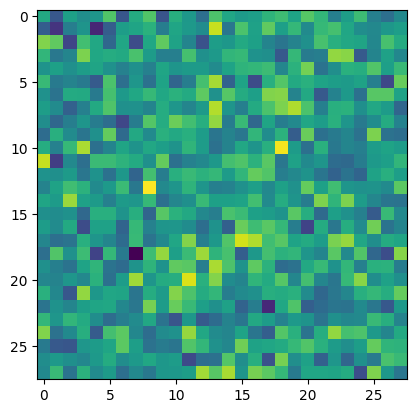

In [574]:
import random
random_image = random.choice(x)
plt.imshow(random_image[0].squeeze())

## experimenting with the model!

In [ ]:
len(loss_graph)

2979

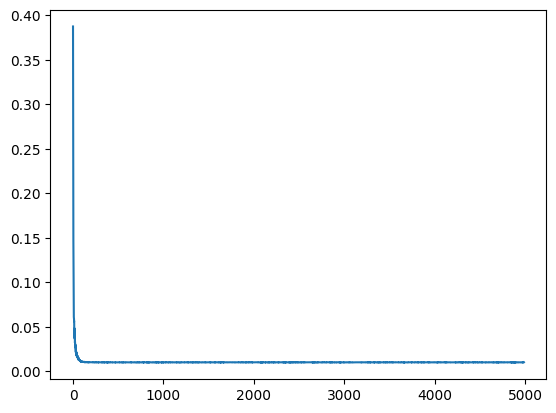

In [179]:
window_size = 1
smoothed_loss = np.convolve(loss_graph, np.ones(window_size)/window_size, mode='valid')
plt.plot(smoothed_loss)

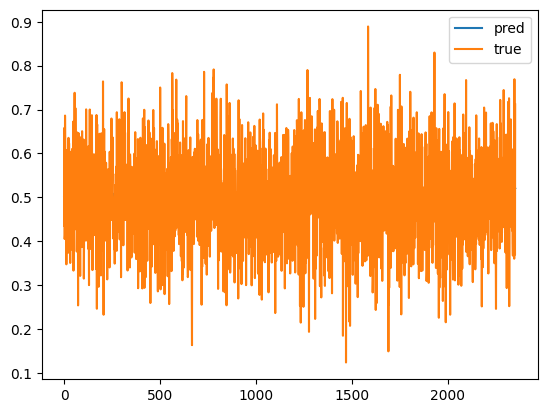

In [180]:
# good gut check for distribution

plt.plot(y_pred[0].flatten().cpu().detach(), label="pred")
plt.plot(y[0].flatten().cpu().detach(), label="true")
plt.legend()
plt.show()

### load weights

In [ ]:
model = DiT(2, 49, 4, 8, latent_dim=64, steps=21, classes=11)
mp = T.load("/Users/neelredkar/Downloads/model_weights_ln_29.tf", map_location=T.device('mps'))
model.load_state_dict(mp)

/var/folders/gl/2h8nn4ps031g1jysgll17wz00000gn/T/ipykernel_35164/1733865722.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mp = T.load("/Users/neelredkar/Downloads/mode

<All keys matched successfully>

In [ ]:
loss_graph = T.load("/Users/neelredkar/Downloads/loss_29.pkl")

/var/folders/gl/2h8nn4ps031g1jysgll17wz00000gn/T/ipykernel_35164/1045397154.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loss_graph = T.load("/Users/neelredkar/Downlo

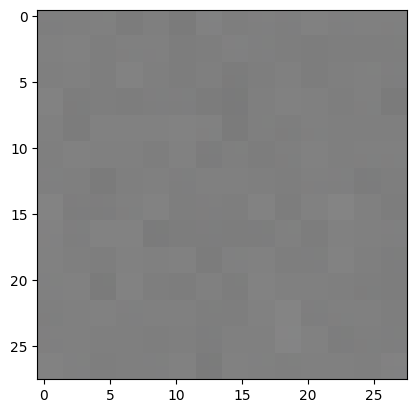

In [184]:
plt.imshow(y_pred[4].cpu().detach().squeeze().T)

In [182]:
def sample(im, t, c):
    assert t < 21
    assert c < 11
    return model(im.to("mps"), T.tensor([t]).unsqueeze(dim=0).to("mps"), T.tensor([c]).unsqueeze(dim=0).to("mps"))

In [ ]:
model.to("mps")

DiT(
  (emb): PositionalEmbedding()
  (transformer_block): ModuleList(
    (0-1): 2 x Transformer(
      (proj): Linear(in_features=49, out_features=64, bias=True)
      (proj_q): Linear(in_features=64, out_features=64, bias=True)
      (proj_k): Linear(in_features=64, out_features=64, bias=True)
      (proj_v): Linear(in_features=64, out_features=64, bias=True)
      (layer_norm1): AdaLN(
        (mean): Linear(in_features=64, out_features=64, bias=True)
        (sd): Linear(in_features=64, out_features=64, bias=True)
        (ln): LayerNorm()
      )
      (layer_norm2): AdaLN(
        (mean): Linear(in_features=64, out_features=64, bias=True)
        (sd): Linear(in_features=64, out_features=64, bias=True)
        (ln): LayerNorm()
      )
      (ffn): Sequential(
        (0): Linear(in_features=64, out_features=196, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=196, out_features=49, bias=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)

In [ ]:
alphas

tensor([1.4062e-01, 8.1166e-02, 3.6742e-02, 9.2871e-03, 3.1870e-33, 9.2871e-03,
        3.6742e-02, 8.1166e-02, 1.4062e-01, 2.1250e-01, 2.9366e-01, 3.8057e-01,
        4.6942e-01, 5.5632e-01, 6.3749e-01, 7.0937e-01, 7.6883e-01, 8.1325e-01,
        8.4071e-01, 8.5000e-01], device='mps:0')

## sampling techniques

1. most basic, just linearly decode

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11.226449..-8.69198].


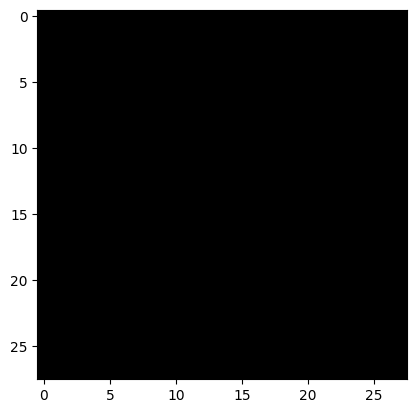

In [188]:
model.eval()
im = T.normal(mean=T.zeros(3, 28,28)+0.5, std=0.1).unsqueeze(dim=0).to("mps")

steps = 21
for i in range(steps):
    im  -= sample(im, i, 3)
plt.imshow(im.squeeze().squeeze().cpu().detach().T)

2. add some cfg

In [215]:
model.eval()
im = T.normal(mean=T.zeros(28,28), std=0.5).unsqueeze(dim=0).unsqueeze(dim=0).to("mps")

steps = 21
for i in range(steps):
    im  -= (sample(im, i, 7) - sample(im, i, 10)*0.9)
plt.imshow(im.squeeze().squeeze().cpu().detach())

RuntimeError: The size of tensor a (4) must match the size of tensor b (12) at non-singleton dimension 1

3. maybe we should scale the noise correctly

In [189]:
beta = 0.15
alpha = 1-beta

alphas = [alpha*cos_scheduler(i) for i in range(20)][::-1]
alphas_prod = T.cumprod(T.tensor(alphas), dim=0).to("mps")
betas = 1 - T.tensor(alphas).to("mps")

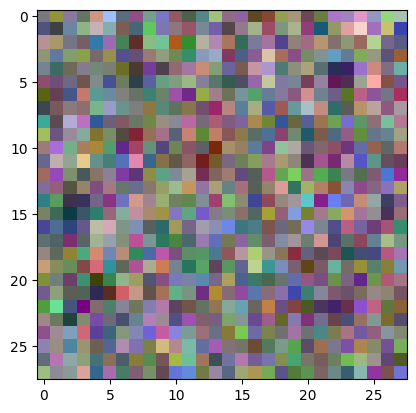

In [217]:
gamma = 2
steps = 20
def random_noise_like(im):
    return T.randn_like(im)
im = random_noise_like(T.zeros(1, 3, 28, 28)).to("mps")

for i in range(steps):
    t = int((i/steps) * 20)
    
    noise  = sample(im, t, 8) - sample(im, t, 10)*0.1

    im  = (1/math.sqrt(alphas[t])) *(im - noise*(1-alphas[t])/(math.sqrt(1-alphas_prod[t]))) + random_noise_like(im)*0.001
    # shift all values to be between 0 and 1
    im = (im - im.min())/(im.max() - im.min())
plt.imshow(im.squeeze().squeeze().cpu().detach().T)

4. treat it like an ode

In [214]:
im = T.normal(mean=T.zeros(28,28), std=0.5).unsqueeze(dim=0).unsqueeze(dim=0).to("mps")
gamma = 2
steps = 40

substeps = 5
for i in range(steps):
    t = int((i/steps) * 20)
    noises = []

    for i in range(substeps):
        noise  = sample(im, t, 3) - sample(im, t, 10)*0.4
        noises.append(noise)
        im -= noise*0.11

    noise = T.vstack(noises).mean(dim=0)
    im  = (1/math.sqrt(alphas[t])) *(im - noise*(1-alphas[t])/(math.sqrt(1-alphas_prod[t])))
plt.imshow(im.squeeze().squeeze().cpu().detach())

RuntimeError: The size of tensor a (4) must match the size of tensor b (12) at non-singleton dimension 1

In [ ]:
model.to("mps")

DiT(
  (emb): PositionalEmbedding()
  (transformer_block): ModuleList(
    (0-1): 2 x Transformer(
      (proj): Linear(in_features=49, out_features=64, bias=True)
      (proj_q): Linear(in_features=64, out_features=64, bias=True)
      (proj_k): Linear(in_features=64, out_features=64, bias=True)
      (proj_v): Linear(in_features=64, out_features=64, bias=True)
      (layer_norm1): AdaLN(
        (mean): Linear(in_features=64, out_features=64, bias=True)
        (sd): Linear(in_features=64, out_features=64, bias=True)
        (ln): LayerNorm()
      )
      (layer_norm2): AdaLN(
        (mean): Linear(in_features=64, out_features=64, bias=True)
        (sd): Linear(in_features=64, out_features=64, bias=True)
        (ln): LayerNorm()
      )
      (ffn): Sequential(
        (0): Linear(in_features=64, out_features=196, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=196, out_features=49, bias=True)
      )
      (dropout): Dropout(p=0.2, inplace=False)

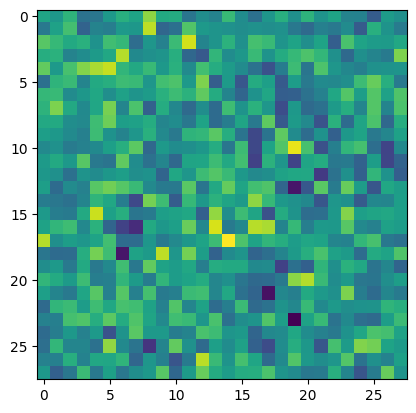

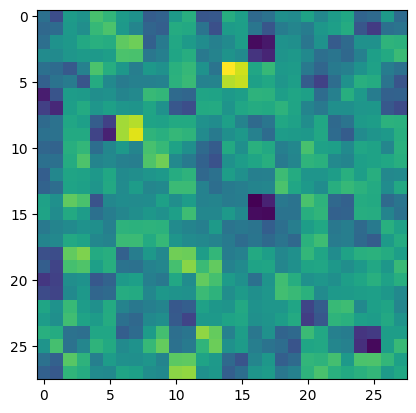

In [ ]:
plt.imshow(mnist[1][0][0] - n)